<a href="https://colab.research.google.com/github/chaudha4/Intro_to_deep_learning/blob/master/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict healthcare costs using a regression algorithm.

We will use `tf.estimator.LinearRegressor` that will predict a label value (health care costs) based on certain feature values (age, smoker etc).


In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 5.4MB/s 


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2020-12-26 21:28:58--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv’

insurance.csv           [ <=>                ]  49.09K  --.-KB/s    in 0s      

2020-12-26 21:28:58 (106 MB/s) - ‘insurance.csv’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


## Analyze the data
Inspect and cleanup

In [ ]:
df = dataset.copy() # deep copy


In [ ]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [ ]:
for cc in ["sex", "smoker", "region"]:
  print("Unique values for ", cc, df[cc].unique())

Unique values for  sex ['female' 'male']
Unique values for  smoker ['yes' 'no']
Unique values for  region ['southwest' 'southeast' 'northwest' 'northeast']


The data looks right. The min age is 18 and max is 64. BMI, children and expenses llok okay too. No outliers in this dataset.

## Feature engineering

Let's convert data to numeric values.

In [ ]:
# Convert Categorical columns to numeric columns
for cc in ["sex", "smoker", "region"]:
  df[cc] = pd.Categorical(df[cc]) # mark the column as categorical.
  df[cc] = df[cc].cat.codes # replace the value with the category.

In [ ]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86
...,...,...,...,...,...,...,...
1333,50,1,31.0,3,0,1,10600.55
1334,18,0,31.9,0,0,0,2205.98
1335,18,0,36.9,0,0,2,1629.83
1336,21,0,25.8,0,0,3,2007.95



## Split the data

Create training and validation data. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.


In [ ]:
split_fraction = 0.80
dftrain=df[0:int(split_fraction * len(df))]

In [ ]:
dftrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.551402,14.141959,18.00,27.0000,40.000,51.7500,64.00
sex,1070.0,0.510280,0.500128,0.00,0.0000,1.000,1.0000,1.00
bmi,1070.0,30.784953,6.085046,16.00,26.4000,30.500,34.9750,52.60
children,1070.0,1.075701,1.191986,0.00,0.0000,1.000,2.0000,5.00
smoker,1070.0,0.200935,0.400887,0.00,0.0000,0.000,0.0000,1.00
region,1070.0,1.515888,1.107517,0.00,1.0000,2.000,2.0000,3.00
expenses,1070.0,13214.126047,12033.808142,1121.87,4740.2875,9333.015,16547.2625,63770.43


In [ ]:
dfeval=df[int(split_fraction * len(df)):]
dfeval.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,268.0,37.832090,13.615568,18.00,25.0000,37.00,50.000,64.00
sex,268.0,0.485075,0.500712,0.00,0.0000,0.00,1.000,1.00
bmi,268.0,30.188433,6.139579,16.80,25.8000,30.00,33.800,53.10
children,268.0,1.171642,1.257345,0.00,0.0000,1.00,2.000,5.00
smoker,268.0,0.220149,0.415122,0.00,0.0000,0.00,0.000,1.00
region,268.0,1.514925,1.096368,0.00,1.0000,2.00,2.000,3.00
expenses,268.0,13495.187761,12429.981840,1135.94,4739.8375,9538.89,17077.175,62592.87


In [ ]:
df.shape

(1338, 7)

In [ ]:
dftrain.shape

(1070, 7)

In [ ]:
dfeval.shape

(268, 7)

In [ ]:
dftrain

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86
...,...,...,...,...,...,...,...
1065,42,0,25.3,1,0,3,7045.50
1066,48,1,37.3,2,0,2,8978.19
1067,39,1,42.7,0,0,0,5757.41
1068,63,1,21.7,1,0,1,14349.85


## Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [ ]:
train_mean = dftrain.mean()
train_std = dftrain.std()

dftrain = (dftrain - train_mean) / train_std
dfeval = (dfeval - train_mean) / train_std


`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

In [ ]:
y_train=dftrain.pop("expenses")
y_eval=dfeval.pop("expenses")


In [ ]:
dftrain

,age,sex,bmi,children,smoker,region
0,-1.453222,-1.020299,-0.474105,-0.902444,1.993245,1.340035
1,-1.523933,0.979188,0.495485,-0.063508,-0.501225,0.437115
2,-0.816818,0.979188,0.364015,1.614364,-0.501225,0.437115
3,-0.463260,0.979188,-1.328659,-0.902444,-0.501225,-0.465806
4,-0.533971,0.979188,-0.309768,-0.902444,-0.501225,-0.465806
...,...,...,...,...,...,...
1065,0.173144,-1.020299,-0.901382,-0.063508,-0.501225,1.340035
1066,0.597414,0.979188,1.070665,0.775428,-0.501225,0.437115
1067,-0.038990,0.979188,1.958086,-0.902444,-0.501225,-1.368726
1068,1.658087,0.979188,-1.492997,-0.063508,-0.501225,-0.465806


In [ ]:
y_train

0       0.305040
1      -0.954692
2      -0.728337
3       0.728809
4      -0.776750
          ...   
1065   -0.512608
1066   -0.352003
1067   -0.619647
1068    0.094378
1069   -0.189905
Name: expenses, Length: 1070, dtype: float64

In [ ]:
dfeval.head()

,age,sex,bmi,children,smoker,region
1070,-0.180414,0.979188,1.037798,-0.063508,1.993245,0.437115
1071,1.658087,0.979188,0.101075,-0.902444,-0.501225,-1.368726
1072,-1.311799,0.979188,0.084641,-0.902444,-0.501225,-0.465806
1073,1.021683,-1.020299,-0.309768,0.775428,-0.501225,-1.368726
1074,1.445952,-1.020299,-2.051743,-0.902444,-0.501225,-1.368726


## Load data using `tf.data.Dataset`

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((dftrain.values, y_train.values))

In [ ]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [-1.45322167 -1.02029942 -0.47410538 -0.90244418  1.99324549  1.34003503], Target: 0.3050400928672032
Features: [-1.52393323  0.97918846  0.49548459 -0.06350824 -0.50122548  0.4371147 ], Target: -0.9546916413228017
Features: [-0.81681764  0.97918846  0.36401476  1.61436366 -0.50122548  0.4371147 ], Target: -0.7283368608749667
Features: [-0.46325984  0.97918846 -1.32865925 -0.90244418 -0.50122548 -0.46580563], Target: 0.7288086904466965
Features: [-0.5339714   0.97918846 -0.3097681  -0.90244418 -0.50122548 -0.46580563], Target: -0.7767504630457096


In [ ]:
# Shuffle and batch the dataset.
train_dataset = dataset.shuffle(len(dftrain)).batch(1)

In [ ]:
def test_model(model, dfeval, y_eval):
  # RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
  # Test model by checking how well the model generalizes using the test set.
  loss, mae, mse = model.evaluate(dfeval, y_eval, verbose=2)

  print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

  if mae < 3500:
    print("You passed the challenge. Great job!")
  else:
    print("The Mean Abs Error must be less than 3500. Keep trying.")

  # Plot predictions.
  test_predictions = model.predict(test_dataset).flatten()

  a = plt.axes(aspect='equal')
  plt.scatter(y_eval, test_predictions)
  plt.xlabel('True values (expenses)')
  plt.ylabel('Predictions (expenses)')
  lims = [0, 50000]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims,lims)

# Linear model

The simplest trainable model is to insert linear transformation between the input and output without applying any activation function.

In [ ]:
def get_linear_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
  ])

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanSquaredError()])
  return model

In [ ]:
model = get_linear_model()

In [ ]:
history = model.fit(train_dataset, epochs=15)

Epoch 1/15
1070/1070 [==============================] - 1s 863us/step - loss: 2.2801 - mean_absolute_error: 1.1285 - mean_squared_error: 2.2801
Epoch 2/15
1070/1070 [==============================] - 1s 863us/step - loss: 0.9353 - mean_absolute_error: 0.6976 - mean_squared_error: 0.9353
Epoch 3/15
1070/1070 [==============================] - 1s 860us/step - loss: 0.4510 - mean_absolute_error: 0.4830 - mean_squared_error: 0.4510
Epoch 4/15
1070/1070 [==============================] - 1s 857us/step - loss: 0.2952 - mean_absolute_error: 0.3882 - mean_squared_error: 0.2952
Epoch 5/15
1070/1070 [==============================] - 1s 858us/step - loss: 0.2498 - mean_absolute_error: 0.3497 - mean_squared_error: 0.2498
Epoch 6/15
1070/1070 [==============================] - 1s 854us/step - loss: 0.2329 - mean_absolute_error: 0.3361 - mean_squared_error: 0.2329
Epoch 7/15
1070/1070 [==============================] - 1s 862us/step - loss: 0.2434 - mean_absolute_error: 0.3513 - mean_squared_error:

9/9 - 0s - loss: 0.2578 - mean_absolute_error: 0.3495 - mean_squared_error: 0.2578
Testing set Mean Abs Error:  0.35 expenses
You passed the challenge. Great job!


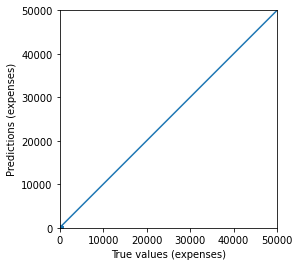

In [ ]:
test_model(model, dfeval, y_eval)

# Dense

We can also introduce non-linearity to make the model more accuarte. We can use `relu` activation function to introduce non linearity.


In [ ]:
def get_nonlinear_model():
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(units=64, activation='relu'),
                               tf.keras.layers.Dense(1)
                                 ])

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanSquaredError()])
  return model

In [ ]:
model = get_nonlinear_model()

In [ ]:
history = model.fit(train_dataset, epochs=15)

Epoch 1/15
1070/1070 [==============================] - 1s 985us/step - loss: 0.5033 - mean_absolute_error: 0.5042 - mean_squared_error: 0.5033
Epoch 2/15
1070/1070 [==============================] - 1s 984us/step - loss: 0.1389 - mean_absolute_error: 0.2260 - mean_squared_error: 0.1389
Epoch 3/15
1070/1070 [==============================] - 1s 986us/step - loss: 0.1672 - mean_absolute_error: 0.2497 - mean_squared_error: 0.1672
Epoch 4/15
1070/1070 [==============================] - 1s 1ms/step - loss: 0.1534 - mean_absolute_error: 0.2360 - mean_squared_error: 0.1534
Epoch 5/15
1070/1070 [==============================] - 1s 986us/step - loss: 0.1578 - mean_absolute_error: 0.2528 - mean_squared_error: 0.1578
Epoch 6/15
1070/1070 [==============================] - 1s 981us/step - loss: 0.1227 - mean_absolute_error: 0.2072 - mean_squared_error: 0.1227
Epoch 7/15
1070/1070 [==============================] - 1s 1ms/step - loss: 0.1567 - mean_absolute_error: 0.2459 - mean_squared_error: 0.1

9/9 - 0s - loss: 0.1686 - mean_absolute_error: 0.2409 - mean_squared_error: 0.1686
Testing set Mean Abs Error:  0.24 expenses
You passed the challenge. Great job!


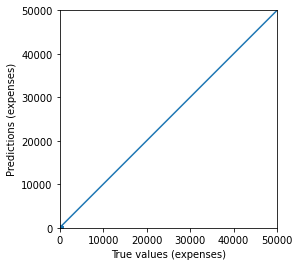

In [ ]:
test_model(model, dfeval, y_eval)